<a href="https://colab.research.google.com/github/lauramoraes/Analise_de_Clusters/blob/master/4%20-%20Comprimindo%20informa%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualização dos dados de alta dimensão

### Importando bibliotecas a serem usadas

In [0]:
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(ggplot2)))

In [0]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

### Carregando os dados salvos anteriormente

In [0]:
list.files()

[1] "0 - Datasets.ipynb"                                                      
[2] "1 - Análise inicial dos dados.ipynb"                                     
[3] "2 - Visualizando os dados.ipynb"                                         
[4] "3 - Entendendo a matriz de covariância.ipynb"                            
[5] "4 - Conectando matriz de covariância e redução de dimensionalidade.ipynb"
[6] "Untitled.ipynb"                                                          
[7] "Untitled1.ipynb"                                                         
[8] "variancia_cumulativa.png"                                                
[9] "variancia_individual.png"

In [0]:
load("data_cleaned.Rdata")
load("data_onehot.Rdata")
head(data_onehot)

Warning message in readChar(con, 5L, useBytes = TRUE):
"não foi possível abrir o arquivo comprimido 'data_cleaned.Rdata', motivo provável 'No such file or directory'"

ERROR: Error in readChar(con, 5L, useBytes = TRUE): não é possível abrir a conexão


### Visualizando em 2D

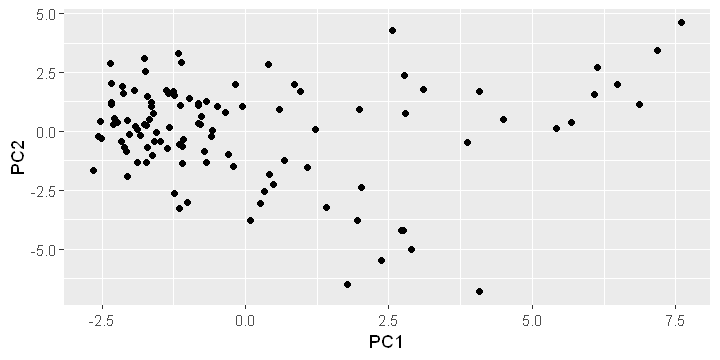

In [0]:
options(repr.plot.width=6, repr.plot.height=3)

pca <- prcomp(data_onehot, scale=TRUE, center=TRUE)
pca_df <- data.frame(x=pca$x[,"PC1"], y=pca$x[,"PC2"])

# Plotando as direções de maior variância
ggplot(data = pca_df, aes(x,y)) + 
  geom_point() + xlab("PC1") + ylab("PC2")

### Adicionando um pouco mais de informação (cores!)
Dá para perceber como a localização é grande parte das componentes principais

In [0]:
options(repr.plot.width=6, repr.plot.height=3)

# Choose column to color
color = "REGION"
# color = "DISTRICT"
# color = "DISTRICT.SPEY"

# Choose dataset version
data = data_cleaned
# data = data_onehot

pca <- prcomp(data_onehot, scale=TRUE, center=TRUE)
pca_df <- data.frame(x=pca$x[,"PC1"], y=pca$x[,"PC2"], color=data[, color])

# Plotando as direções de maior variância
ggplot(data = pca_df, aes(x,y, color=color)) + 
  geom_point() + xlab("PC1") + ylab("PC2")

ERROR: Error in eval(expr, envir, enclos): objeto 'data_cleaned' não encontrado


### Como vamos para um espaço reduzido que equilibre quantidade de informação e erro?
Podemos escolher ir para dimensões baixas (que vimos que nos ajuda a **visualizar**), mas, se o nosso dado tiver muitos atributos essas dimensões não são suficientes para conter **toda a informação** necessária para uma análise, deixando o **erro** em relação à informação original **muito grande**. Além disso, nem sempre precisamos visualizar o dado. Se quisermos utilizar essa informação para eliminar ruído e realizar um **agrupamento ou um sistema de recomendação**, podemos ainda trabalhar em dimensões altas (mas não tão altas quanto o original). Mas qual seria uma dimensão boa?

#### Variância explicada ou erro acumulado
Uma técnica utilizada é verificar o quanto que cada nova dimensão está contribuindo na explicação do dado (aumento da variância ou diminuição do erro). Em determinado momento, as novas dimensões contribuem tão pouco que podemos dispensá-las. Essa técnica é chamada de "cotovelo" ou "joelho", pois no ponto em que as dimensões passam a contribuir bem menos do que vinham contribuindo antes, a curva forma um joelho.

In [0]:
# Resultado do PCA
summary(pca)

ERROR: Error in summary(pca): objeto 'pca' não encontrado


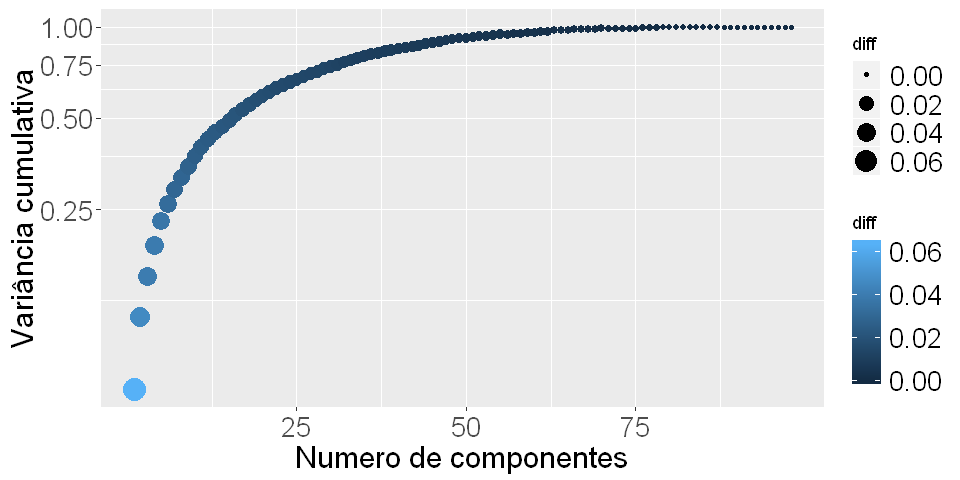

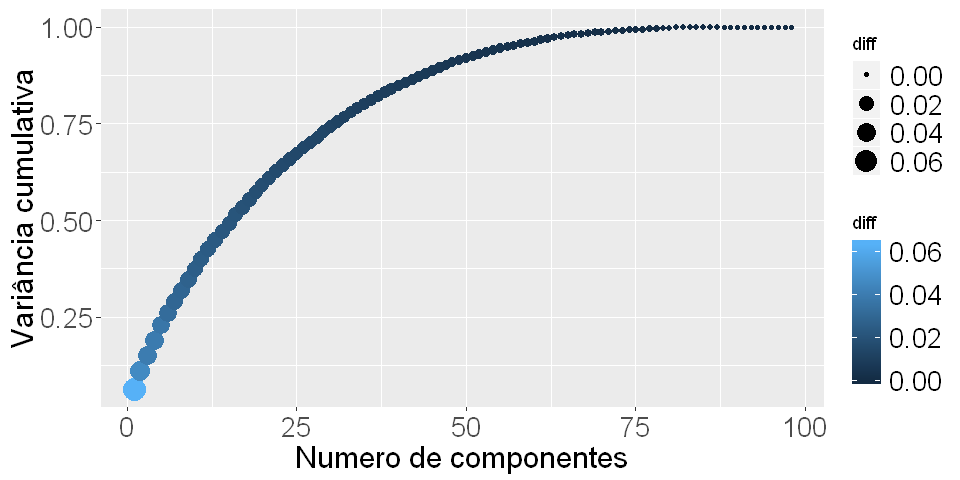

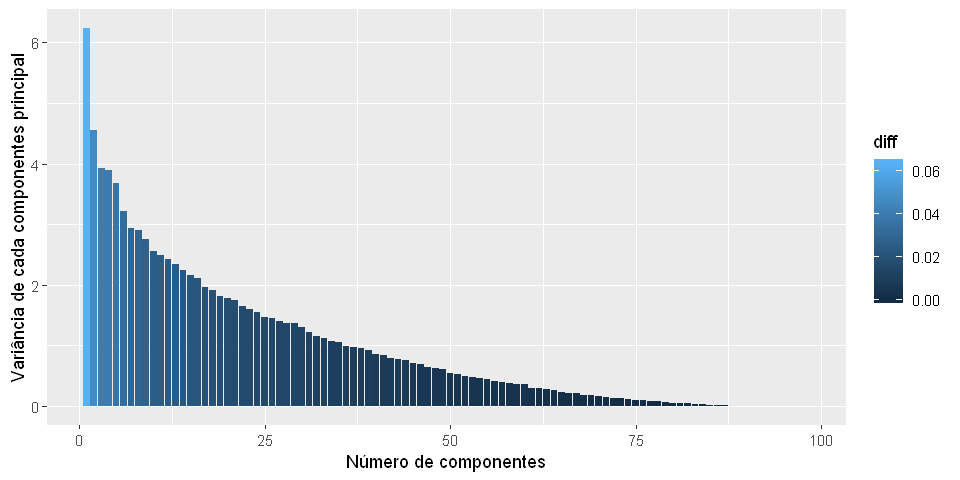

In [0]:
options(repr.plot.width=8, repr.plot.height=4)

variancia_explicada <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
shifted <- c(0, variancia_explicada)
diff <- c(variancia_explicada, 1) - shifted
var_df <- data.frame(x=1:nrow(matrix(variancia_explicada)), 
                     y=variancia_explicada, 
                     y2=pca$sdev^2,
                     diff=matrix(diff)[-nrow(matrix(diff))])

# png(filename="variancia_cumulativa.png", width = 600, height = 300, res=72)
ggplot(data = var_df, aes(x,y, color=diff, size=diff)) + 
  geom_point() + xlab("Numero de componentes") + ylab("Variância cumulativa") +
  theme(axis.title=element_text(size=18), axis.text=element_text(size=16),
       legend.text=element_text(size=16)) + coord_trans(y = "log10")
# dev.off()

# png(filename="variancia_cumulativa.png", width = 600, height = 300, res=72)
ggplot(data = var_df, aes(x,y, color=diff, size=diff)) + 
  geom_point() + xlab("Numero de componentes") + ylab("Variância cumulativa") +
  theme(axis.title=element_text(size=18), axis.text=element_text(size=16),
       legend.text=element_text(size=16))
# dev.off()

# png(filename="variancia_individual.png")
ggplot(data = var_df, aes(x,y2, fill=diff)) + 
  geom_bar(stat="identity") + xlab("Número de componentes") + ylab("Variância de cada componentes principal")
# dev.off()